# Precision and Recall

## Introduction
Precision and Recall is a method for evaluating pipelines, when given ground truth. I will be demonstrating how precision and recall works in this notebook on our connectLib pipeline. 

## Simulation Data

**Description:** Validation testing will be performed on a a 100x100x100 volume with a pixel intensity distribution approximately the same as that of the true image volumes (i.e., 98% background, 2% synapse). The synapse pixels will be grouped together in clusters as they would in the true data. Based on research into the true size of synapses, these synthetic synapse clusters will be given area of ~1 micron ^3, or about 139 voxels (assuming the synthetic data here and the real world data have identical resolutions). After the data goes through the algorithm, I will gauge performance based on the following:

Precision: out of total clusters detected by pipeline, how many were actually true synapses.
Recall: out of total true synapses, how many were detected by the pipeline.


** Raw Synthetic Data:**

In [3]:
import sys
sys.path.insert(0, '../code/functions/')
import connectLib as cLib
from random import randrange as rand
import itertools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
import math
from cluster import Cluster
from mpl_toolkits.mplot3d import Axes3D


def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 5):
        for y in range(-1, 5):
            for x in range(-1, 5):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    clusterList = []
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
            potentialPointSet = generatePointSet()
            clusterList.append(Cluster(list(potentialPointSet)))
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume, noiseVolume, clusterList

testVolume = generateTestVolume()
foreground = testVolume[0]
combinedIm = testVolume[1]
trueClusterList = testVolume[2]


**What We Expect Our Simulation Data Will Look Like:**
The above code should generate a 100x100x100 volume and populate it with various, non-intersectting pointsets (representing foreground synpases). When the foreground is generated, the volume will then be introduced to random background noise which will fill the rest of the volume. 

###  Simulation Plots

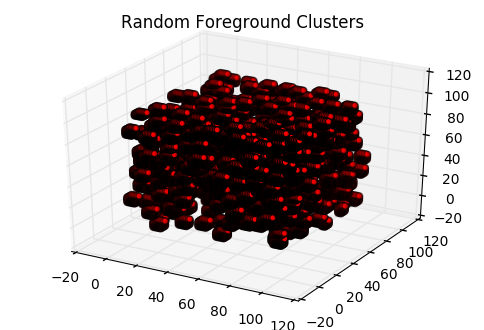

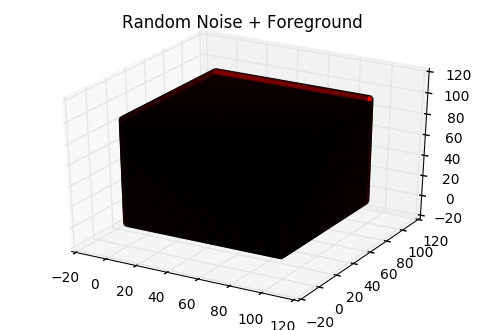

In [4]:
#displaying the random clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = foreground.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Foreground Clusters')
plt.show()

#displaying the noise
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = combinedIm.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Noise + Foreground')
plt.show()

**Why Our Simulation is Correct:** Real microscopic images of synapses usually contain a majority of background noise and relatively few synapse clusters. As shown above, the generated test volume follows this expectation. 

# Simulation Analysis

**For our algorithm, we define a cluster from the pipeline output as a true postive if any of its members is in the true synapse list. **

## Pseudocode for Precision and Recall

**Inputs: ** Two lists of synapse clusters

**Outputs: ** Precision and Recall Statistics.

In [ ]:
####Pseudocode: Will not run!####

#Step 1: Calculate True Postitives, False Negatives, and False Postitives.
FOR every synapse cluster in test volume:
    FOR every synapse cluster in true volume:
        IF test synapse cluster members in true synapse cluster members:
            True Postive Count + 1
ENDFOR

False Postive Count = Total Test Synapse Cluster Count - True Positive Count
False Negative Count = Total True Synapse Cluster Count - True Positive Count

#Step 2: Calculate Precision and Recall.
Precision = True Positive Count / (False Postive Count + True Postive Count)
Recall = True Positive Count / (False Negative Count + True Positive Count)

#Step 3: Generate f1 Score. 
f1 = 2*Precision*Recall/ (Precision + Recall)

## Actual Code for Precision and Recall

In [ ]:
def f1score(trueClusterList, testClusterList):
    
    tp = 0
    fp = 0
    fn = 0
    '''
    for testCluster in testClusterList:
        for trueCluster in trueClusterList:
            if(bool(set(tuple(testCluster.members.tolist()).intersection(set(tuple(trueCluster.members)))))):
                tp +=1
    '''
    testClusterTuples = []
    for elem in testClusterList:
        myTupleList = []
        members = elem.members
        for member in members:
            myTupleList.append(tuple(member))
        testClusterTuples.append(myTupleList)

    trueClusterTuples = []
    for elem in trueClusterList:
        myTupleList = []
        members = elem.members
        for member in members:
            myTupleList.append(tuple(member))
        trueClusterTuples.append(myTupleList)
    
    truePositives = []
    for testList in testClusterTuples:
        found = False
        for trueList in trueClusterTuples:
            if len(set(testList).intersection(set(trueList))) > 0:
                found = True
        if found:
            truePositives.append(testList)
            tp+=1
    
    print tp      
    fp = len(testClusterList) - tp
    fn = len(trueClusterList) - tp
    print fp
    print fn
    precision = float(tp)/float(fp+tp)
    print precision
    recall = float(tp)/float(tp+fn)
    print recall
    f1 = (2*precision*recall)/(precision+recall)
    
    return precision, recall, f1, truePositives, trueClusterTuples, testClusterTuples

## Pipeline code

In [ ]:
import sys
sys.path.insert(0, '../functions/')
import cv2
import plosLib as pLib
import connectLib as cLib
from cluster import Cluster
import mouseVis as mv
import tiffIO as tIO
import cPickle as pickle
import hyperReg as hype
from scipy import ndimage
import matplotlib.pyplot as plt

def analyzeTimepoint(tiffImage, plosNeighborhood, plosLowerZBound, plosUpperZBound, debug=False):
    #finding the clusters after plosPipeline
    plosOut = pLib.pipeline(tiffImage, plosNeighborhood, plosLowerZBound, plosUpperZBound)
    #binarize output of plos lib
    bianOut = cLib.otsuVox(plosOut)
    
    #dilate the output based on neigborhood size
    for i in range(int((plosNeighborhood+plosUpperZBound+plosLowerZBound)/3.)):
        bianOut = ndimage.morphology.binary_dilation(bianOut).astype(int)
    #run connected component
    connectList = cLib.connectedComponents(bianOut)

    if debug:
        print connectList, bianOut

    return connectList

## Simulation Analysis
**What We Expect**
As previously mentioned, we believe the pipeline will work very well on the easy simulation (See Simulation Data for explanation).

**Generate Simulation Data:** See Simulation Data Above.

### Pipeline Run on Simulation Data

In [ ]:
testClusterList = analyzeTimepoint(combinedIm, 1, 1, 1, False)

### Simulation Results 

In [ ]:
stats = f1score(trueClusterList, testClusterList)

In [ ]:
print 'Precision:' + str(stats[0])
print 'Recall:' + str(stats[1])
print 'f1 Score:' + str(stats[2])


In [ ]:
# Getting true postive, false positive and false negative members

truePositiveClusters = stats[3]
trueTupleClusters = stats[4]
testTupleClusters = stats[5]

truePositiveMembers = []
falseNegativeMembers = []
falsePositiveMembers = []

#Takes too long to run... any suggestions for faster correspondence?
for cluster in truePositiveClusters:
    for member in cluster:
        truePositiveMembers.append(member)
print 'done'
for cluster in testTupleClusters:
    for member in cluster:
        if (member not in truePositiveMembers):
            falsePositiveMembers.append(member)
print 'done'
for cluster in trueTupleClusters:
    for member in cluster:
        if (member not in truePositiveMembers):
            falsePositiveMembers.append(member)

In [ ]:
#Plotting centroids for truepositive and actual clsuters

#Getting centroids:
trueCentroids = []
testCentroids = []
for cluster in trueClusterList:
    trueCentroids.append(cluster.getCentroid())
for cluster in testClusterList:
    testCentroids.append(cluster.getCentroid())

In [ ]:
# plotting centroids

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode()

trace0 = Scatter3d(
    x=[centroid[2] for centroid in trueCentroids],
    y=[centroid[1] for centroid in trueCentroids],
    z=[centroid[0] for centroid in trueCentroids],
    mode='markers',
    marker=dict(
        size=3,
    )
)

trace1 = Scatter3d(
    x=[centroid[2] for centroid in testCentroids],
    y=[centroid[1] for centroid in testCentroids],
    z=[centroid[0] for centroid in testCentroids],
    mode='markers',
    marker=dict(
        size=3
    )
)
data = [trace0, trace1]
layout = Layout(
    showlegend=False,
)

fig = dict( data=data, layout=layout )

iplot(fig)  


## First Glance

At a first glance, these results are very disturbing. Although the clusters haven't been directly corresponded yet, you can see that most of the test centroids and true centroids do not overlap. This proves that the PLOS box filter is not degrading our synapse clusters correctly.

In [ ]:
## Next graph: Plotting all true cluster members and the centroids of the true positive clusters.

## Getting true postive clusters
truePositiveClusters = [Cluster(list(members)) for members in stats[3]]
truePositiveCentroids = [cluster.getCentroid() for cluster in truePositiveClusters]
trace0 = Scatter3d(
    x=[centroid[2] for centroid in trueCentroids],
    y=[centroid[1] for centroid in trueCentroids],
    z=[centroid[0] for centroid in trueCentroids],
    mode='markers',
    marker=dict(
        size=3,
        
    ),
    opacity=.8
)

trace1 = Scatter3d(
    x=[centroid[2] for centroid in truePositiveCentroids],
    y=[centroid[1] for centroid in truePositiveCentroids],
    z=[centroid[0] for centroid in truePositiveCentroids],
    mode='markers',
    marker=dict(
        size=3
    )
)
data = [trace0, trace1]
layout = Layout(
    showlegend=False,
)

fig = dict( data=data, layout=layout )

iplot(fig)

## True Positives compared with True Clusters:

This is even more concering. Even the true positives do not line up with the centroids of the true clusters. Since all our clusters were cubes, the PLOS filter should have eroded each one to its center. Clearly, this is not the case. This means our algorithm is actually just not working correctly. The detected clusters that are considered "true positives" are contained within the true clusters but are mostly shifted away by some degree. 

